# Unsloth Problem 2 - Make `QLoRA` work with `FSDP2` 

This is the **Kaggle 2xT4** notebook, run for 60 steps.

---
---
---
<a name="FSDP2"></a>
## B) Make `QLoRA` work with `FSDP2` [Difficulty: Medium to Hard] [Max points: 10]

1. Goal: Write a single Python script to finetune Llama 3.1 8B on 2x or more GPUs with FSDP2.

2. You must showcase this working in a free **Kaggle notebook with 2 x Tesla T4 GPUs**.

3. Pipeline parallelism is also fine, but must utilize [`zero bubble scheduling`](https://pytorch.org/docs/stable/distributed.pipelining.html#torch.distributed.pipelining.schedules.ScheduleInterleavedZeroBubble) somehow.

4. Can use a pre-quantized 4bit BnB safetensor file from [Unsloth's HF page](https://huggingface.co/unsloth) or a full 16bit one, but must do QLoRA.

5. Can use `accelerate` but must be FSDP2 or related - you can investigate https://github.com/huggingface/accelerate/pull/3394, Torch Titan, other repos etc.

6. Must be fully `transformers` compatible - so we must use `TrainingArguments` and `Trainer`, or `TRL` related classes.

7. The loss must be equivalent to single GPU training.

8. You must enable all features in FSDP2 - ie showcase offloading, checkpointing, mixed precision training etc.

9. You can use `nf4` from `torch AO`, but best from `bitsandbytes`.

10. Finally showcase everything working in a free Kaggle 2x Tesla T4 notebook.

In [1]:
# Code to install Unsloth, Triton, Torch etc

# For FSDP2 we need torch >= 2.6.0 (Many version incompatabilities, but we can hack something together)
# NOTE: Many sources suggest FSDP2 is supported as of torch>=2.5.1, but it may have been experimental then?
!pip install --no-cache-dir --force-reinstall datasets huggingface_hub hf_transfer
!pip install --no-cache-dir --force-reinstall bitsandbytes peft trl matplotlib

# Need some changes to `accelerate` to support FSDP2 in accelerate
!pip install --no-cache-dir git+https://github.com/byi8220/accelerate.git@experimental/qlora-fsdp2

# Torch 2.6.0 for FSDP2
!pip install --no-cache-dir --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# Upgrading torch leads to version breakages relating to numpy, transformers, scipy
# https://github.com/scipy/scipy/issues/21014
!pip install --no-cache-dir --force-reinstall numpy==1.26.1

# Install from head to get access to https://github.com/huggingface/transformers/pull/37147
!pip install --no-cache-dir git+https://github.com/huggingface/transformers.git 
!pip install --no-cache-dir --force-reinstall scipy==1.11.2

!pip install ipywidgets # Needed to export to github

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 282.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 247.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 215.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 152.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 259.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 271.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 294.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 296.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 297.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# We must set env vars before importing torch
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
os.environ["NCCL_P2P_DISABLE"] = "1"

## FSDP2 Enabled Model
We are launching the script in https://www.kaggle.com/code/byi8220/fsdp2-qlora-py/notebook via `accelerate`.

The choice to use `accelerate` stems from the requirement that the solution "Must be fully `transformers` compatible - so we must use `TrainingArguments` and `Trainer`, or `TRL` related classes."

Since `TRL` uses an `accelerator` under the hood (see [TRL docs](https://github.com/huggingface/trl/blob/main/docs/source/distributing_training.md)), the least invasive option appears to be to interop with `accelerate`.

In [3]:
%%writefile fsdp_config.yaml
# Since we are doing FSDP (even though it's multi-GPU), we need to specify the distributed type as FSDP
distributed_type: FSDP
# Can be one of "no", "fp16", or "bf16" (see `transformer_engine.yaml` for `fp8`, but it works for FSDP as well)
mixed_precision: 'fp16'
# Specify the number of GPUs to use
num_processes: 2
# Then we can specify the FSDP config
fsdp_config:
  fsdp_activation_checkpointing: true
  fsdp_auto_wrap_policy: TRANSFORMER_BASED_WRAP
  fsdp_backward_prefetch: BACKWARD_PRE
  fsdp_cpu_ram_efficient_loading: true # Required for Qlora https://github.com/huggingface/accelerate/issues/1620
  fsdp_forward_prefetch: false
  fsdp_offload_params: false
  fsdp_sharding_strategy: FULL_SHARD
  fsdp_state_dict_type: SHARDED_STATE_DICT
  fsdp_sync_module_states: true
  fsdp_use_orig_params: true
  # fsdp_version: 2 # We are converting from fsdp1->fsdp2

Writing fsdp_config.yaml


### Porting Params4Bit tensors into a DTensor

FSDP2 handles parameter sharding by converting ordinary tensors into `DTensor` objects. DTensors are a *Tensor Parallel* abstraction, where an individual tensor
is partitioned into shards.

From the docstring for `fully_shard`:
```
    At initialization, FSDP shards the module's parameters across the data
    parallel workers given by ``mesh``. Before forward, FSDP all-gathers the
    sharded parameters across the data-parallel workers to get the unsharded
    parameters for forward computation. If ``reshard_after_forward`` is
    ``True``, then FSDP frees the unsharded parameters after forward and
    re-all-gathers them in backward before gradient computation.
```
In other words, for any worker, its parameters live in distributed space, however is fully colocated for any computation. This means that in theory, we can
dequantize and then matmul using a quantized parameter by letting FSDP2 be responsible for materializing the full tensor beforehand.

In [4]:
%%writefile train.py
# Get FSDP2 working
# FSDP2 interface (https://pytorch.org/docs/stable/distributed.fsdp.fully_shard.html)

# Patching huggingface repos is a mess. I needed to hack a patch into `Trainer._inner_training_loop`, which is not clean
import os 
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.distributed.fsdp import fully_shard, CPUOffloadPolicy, MixedPrecisionPolicy
from torch.distributed.device_mesh import init_device_mesh
from accelerate import notebook_launcher, FullyShardedDataParallelPlugin

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
import torch
import time
import transformers.trainer
from bitsandbytes.nn.modules import Linear4bit as bnb_Linear4bit
from peft.tuners.lora.bnb import Linear4bit as peft_Linear4bit

# FSDP2 shards parameters across devices, which interferes with quantized parameters.
# The naive solution to this problem is to not shard quantized parameters across multiple GPUs
def patch_fsdp():
    from torch.distributed.fsdp._fully_shard._fsdp_param import FSDPParam
    _init_dtype_attrs = FSDPParam.init_dtype_attrs

    # Patch init_dtype_attrs to not cast quantized types to float
    def _patched_init_dtype_attrs(self, mp_policy):
        param_dtype, reduce_dtype = (mp_policy.param_dtype, mp_policy.reduce_dtype)
        self.orig_dtype = self.sharded_param.dtype
        # Clamp `param_dtype` to `None` if no casting is required
        if param_dtype == self.orig_dtype:
            param_dtype = None

        # Quantized int types shouldn't be cast to float 
        int_types = [torch.uint8, torch.uint16, torch.uint32, torch.uint64]
        if self.orig_dtype in int_types:
            param_dtype = None
            quant_dtype = self.orig_dtype

        self.param_dtype = param_dtype
        self.reduce_dtype = reduce_dtype
        # None indicates that the mixed precision is not enabled


    # Patch `init_sharded_param` to initialize sharded params without gradient.
    # Tbh there is only a single line of diff between this and the baseline init_sharded_param. 
    # I raised a question in pytorch forums about this as well since it bothered me enough: https://discuss.pytorch.org/t/very-small-stupid-question-about-fsdpparam-init-sharded-param/218875
    FSDPParam.init_dtype_attrs = _patched_init_dtype_attrs

    # Include imports for patching.
    import inspect
    import itertools
    from dataclasses import dataclass, field
    from enum import auto, Enum
    from typing import Any, Callable, cast, List, Optional, Sequence, Tuple
    
    import torch
    import torch.nn as nn
    from torch._prims_common import make_contiguous_strides_for
    from torch.distributed._functional_collectives import AsyncCollectiveTensor
    from torch.distributed.tensor import DTensor, Replicate, Shard
    from torch.distributed.tensor._dtensor_spec import DTensorSpec, TensorMeta
    from torch.distributed.tensor.device_mesh import _mesh_resources
    from torch.distributed.tensor.placement_types import _StridedShard, Placement
    from torch.distributed.fsdp._fully_shard._fsdp_api import CPUOffloadPolicy, MixedPrecisionPolicy, OffloadPolicy
    from torch.distributed.fsdp._fully_shard._fsdp_common import (
        _chunk_with_empty,
        _from_local_no_grad,
        _get_dim_chunked_size,
        _raise_assert_with_print,
        _to_dtype_if_needed,
        compiled_autograd_enabled,
        FSDPMeshInfo,
        HSDPMeshInfo,
    )
    from torch.distributed.fsdp._fully_shard._fsdp_param import (
        ShardedState,
        ParamModuleInfo,
        ExtensionsData,
    )
    @torch.no_grad()
    def _patched_init_sharded_param(
        self,
        param: nn.Parameter,
        device: torch.device,
        shard_placement_fn: Optional[Callable],
    ):
        if param.device != device and param.device.type != "meta":
            raise AssertionError(
                f"Expects the parameter to already be moved to device {device} but got {param.device}"
            )
        if not param.is_contiguous():
            raise NotImplementedError(
                f"FSDP does not support non-contiguous parameters yet: {param.shape=} {param.stride()=}"
            )
        fsdp_placement = shard_placement_fn(param) if shard_placement_fn else None
        if fsdp_placement is None:
            fsdp_placement = Shard(0)
        elif fsdp_placement.dim < 0:
            fsdp_placement = Shard(fsdp_placement.dim + param.ndim)
        assert isinstance(fsdp_placement, Shard), f"{fsdp_placement}"
        self.fsdp_placement = fsdp_placement
        shard_dim = fsdp_placement.dim
        # TODO: Replace the sharded DTensor parameter construction logic with
        # `distribute_tensor` after https://github.com/pytorch/pytorch/issues/116101
        # TODO: Simplify the following sharded parameter padding logic after
        # https://github.com/pytorch/pytorch/issues/113045
        self.is_dtensor = isinstance(param, DTensor)
        if self.is_dtensor:
            self._tp_spec = cast(DTensor, param)._spec
            dp_mesh, tp_mesh = (self.mesh_info.mesh, self._tp_spec.mesh)
            dp_global_mesh = _mesh_resources.get_root_mesh(dp_mesh)
            tp_global_mesh = _mesh_resources.get_root_mesh(tp_mesh)
            if dp_global_mesh != tp_global_mesh or (
                dp_global_mesh is None or tp_global_mesh is None
            ):
                raise AssertionError(
                    "FSDP requires the DP and TP mesh to have the same parent mesh but got: \n"
                    f"DP's global mesh: {dp_global_mesh}\nTP's global mesh: {tp_global_mesh}"
                )
            name_dims_error = "FSDP requires named DeviceMesh dims for ND parallelism"
            assert dp_mesh.mesh_dim_names is not None, name_dims_error
            assert tp_mesh.mesh_dim_names is not None, name_dims_error
            submesh_names = dp_mesh.mesh_dim_names + tp_mesh.mesh_dim_names
            self._spmd_mesh = dp_global_mesh[submesh_names]
            if len(self._tp_spec.placements) != 1:
                raise NotImplementedError(
                    f"FSDP only supports 1D TP, not {self._tp_spec.placements}"
                )
            split_factor = self._tp_spec.num_shards_map[shard_dim]
            assert (
                2 <= self._spmd_mesh.ndim <= 3
            ), f"_spmd_mesh.ndim can only be 2 or 3 but got {self._spmd_mesh.ndim}."
            self._spmd_placements: Tuple[Placement, ...]
            dp_shard_tp_placement = (
                (
                    _StridedShard(shard_dim, split_factor=split_factor)
                    if split_factor > 1
                    else fsdp_placement
                ),
                self._tp_spec.placements[0],
            )
            if self._spmd_mesh.ndim == 2:
                self._spmd_placements = dp_shard_tp_placement
            else:
                assert self.mesh_info.replicate_mesh_dim == 0
                self._spmd_placements = (Replicate(),) + dp_shard_tp_placement
            self._sharding_spec = DTensorSpec(
                self._spmd_mesh,
                self._spmd_placements,
                tensor_meta=self._tp_spec.tensor_meta,
            )
            # TODO: Enable uneven sharding for FSDP+TP.
            if split_factor > 1:  # FSDP has strided sharding on tensor dim 0
                num_shards = self._sharding_spec.num_shards_map[0]
                tensor_size_dim_0 = self._sharding_spec.shape[0]
                if tensor_size_dim_0 % num_shards != 0:
                    raise NotImplementedError(
                        "FSDP+TP sharding does not support uneven sharding for now: "
                        f"tensor dim 0 has size {tensor_size_dim_0} which cannot be "
                        f"evenly sharded into {num_shards} shards."
                    )
            param_data = cast(DTensor, param)._local_tensor
        else:
            self._spmd_mesh = self.mesh_info.mesh
            if isinstance(self.mesh_info, HSDPMeshInfo):
                self._spmd_placements = (Replicate(), fsdp_placement)
            else:
                self._spmd_placements = (fsdp_placement,)
            self._sharding_spec = DTensorSpec(
                self._spmd_mesh,
                self._spmd_placements,
                tensor_meta=TensorMeta(param.size(), param.stride(), param.dtype),
            )
            param_data = param
        assert param_data.is_contiguous(), f"{param_data.shape=} {param_data.stride()=}"
        shard_dim = fsdp_placement.dim
        if shard_dim >= param_data.ndim:
            raise AssertionError(
                f"Shard dim {shard_dim} is invalid for {param_data.ndim}D tensor: {param.shape}"
            )
        self._orig_size = param_data.size()
        self._contiguous_orig_stride = make_contiguous_strides_for(self._orig_size)
        shard_rank = self.mesh_info.shard_mesh_rank
        shard_world_size = self.mesh_info.shard_mesh_size
        if shard_dim > 0 and param_data.size(shard_dim) % shard_world_size != 0:
            # If sharding on nonzero dim, require even sharding for now because
            # the uneven sharding (1) requires extra copies before/after FSDP
            # collectives and (2) introduces extra complexity to handle padding
            # and unpadding
            raise NotImplementedError(
                f"FSDP does not support uneven sharding on dim {shard_dim}: "
                f"{param_data.size()} (world size: {shard_world_size})"
            )
        chunks = _chunk_with_empty(param_data, shard_world_size, dim=shard_dim)
        sharded_param = chunks[shard_rank]
        self.sharded_size = _get_dim_chunked_size(
            sharded_param, param_data.size(), dim=shard_dim
        )
        self.contiguous_sharded_stride = make_contiguous_strides_for(self.sharded_size)
        padded_sharded_size = chunks[0].size()  # 0th always padded
        self.padded_sharded_param_size = padded_sharded_size
        # Pre-pad the sharded parameter to avoid padding before all-gather
        padded_sharded_param = param_data.new_zeros(padded_sharded_size)
        if sharded_param.numel() > 0:
            padded_sharded_param.narrow(
                dim=shard_dim, start=0, length=sharded_param.size(shard_dim)
            ).copy_(sharded_param)
        if self.offload_to_cpu and not padded_sharded_param.is_meta:
            padded_sharded_param = padded_sharded_param.cpu()
            if self.pin_memory:
                padded_sharded_param = padded_sharded_param.pin_memory(
                    device=self.device
                )
        self._sharded_param_data = padded_sharded_param.view(-1)
        length = sharded_param.size(shard_dim) if sharded_param.numel() > 0 else 0
        sharded_param = padded_sharded_param.narrow(
            dim=shard_dim, start=0, length=length
        )
        assert sharded_param.is_contiguous(), f"{self.fsdp_placement=}"
        self.sharded_param = nn.Parameter(self.to_sharded_dtensor(sharded_param), requires_grad=param.requires_grad) # Literally a ONE line diff!
        self.sharded_param.requires_grad_(param.requires_grad)
        # Let `param_data` be freed normally when its ref count reaches 0 when
        # the `fully_shard` call returns to allow provided parameters to alias
        self._setattr_on_modules(self.sharded_param)
        self.sharded_state = ShardedState.SHARDED

    _init_sharded_param = FSDPParam._init_sharded_param
    FSDPParam._init_sharded_param = _patched_init_sharded_param
    
import os
def fsdp_main(world_size):
    # For reproducability between training runs
    import random
    import numpy as np
    os.environ["PYTHONHASHSEED"] = "3407"
    random.seed(3407)
    np.random.seed(3407)
    torch.manual_seed(3407)
    torch.cuda.manual_seed(3407)
    torch.cuda.manual_seed_all(3407)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    patch_fsdp()
    mp_policy = os.environ.get("ACCELERATE_MIXED_PRECISION", "fp16")
    print("mp_policy:", mp_policy)
    rank = os.environ.get("LOCAL_RANK", "0")
    torch.cuda.set_device(int(rank))
    max_seq_length = 2048
    model_name = "unsloth/meta-Llama-3.1-8B-Instruct-bnb-4bit"
    param_type = torch.float32 # Everything in accelerate fsdp2 is upcast to float32
    # if mp_policy == "fp16": param_type = torch.float16
    if mp_policy == "bf16": param_type = torch.bfloat16
    bnb_config = BitsAndBytesConfig(
        load_in_4bit              = True,
        bnb_4bit_use_double_quant = True,
        bnb_4bit_quant_type       = "nf4",
        bnb_4bit_compute_dtype    = param_type,
        llm_int8_skip_modules = ["lm_head", "multi_modal_projector", "merger", "modality_projection"],
    )
    print("Visible devices", os.environ.get("CUDA_VISIBLE_DEVICES"))
    device_map = {"": torch.cuda.current_device()}
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map=device_map,
        attn_implementation = "sdpa",
        quantization_config = bnb_config,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "right"
    
    lora_config = LoraConfig(
        r = 64,
        lora_alpha = 128,
        target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                          "gate_proj", "up_proj", "down_proj"],
        lora_dropout = 0,
        bias = "none",
        task_type = TaskType.CAUSAL_LM,
    )

    # Get LoRA and setup model
    model = get_peft_model(model, lora_config)

    int_count = 0
    nonint_count = 0
    int_bytes = 0
    nonint_bytes = 0
    for n, p in model.named_parameters():
        if p.dtype == torch.uint8:
            int_bytes += p.numel() * p.element_size()
            int_count += 1
        else:
            nonint_bytes += p.numel() * p.element_size()
            nonint_count += 1
    print(int_count, nonint_count)
    print(int_bytes / (1024 ** 3), nonint_bytes / (1024 ** 3))
    with torch.no_grad():
        for name, param in model.named_parameters():
            if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
            else: param.requires_grad_(False)

    model.gradient_checkpointing_enable()
    model.enable_input_require_grads()
    # Get dataset
    from datasets import load_dataset
    from trl import SFTTrainer, SFTConfig
    url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
    dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")
    
    assert torch.cuda.device_count() == 2
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    trainer = SFTTrainer(
        model = model,
        train_dataset = dataset,
        processing_class = tokenizer,
        args = SFTConfig(
            per_device_train_batch_size = 2,
            gradient_accumulation_steps = 4 // world_size, # 2 GPU x 2 steps = 1 GPU x 4 steps
            warmup_steps = 1,
            max_steps = 60,
            logging_steps = 1,
            output_dir = f"outputs-{world_size}xGPU",
            overwrite_output_dir = True, 
            seed = 3407,
            max_seq_length = max_seq_length,
            fp16 = mp_policy == "fp16",  # These seem to override the `accelerate` config's MP policy.
            bf16 = mp_policy == "bf16",  # Maybe worth looking into/raising an issue with the TRL/transformers team.
            report_to = "none", # For W&B
            dataset_num_proc = 4,
            average_tokens_across_devices = world_size > 1,
            gradient_checkpointing_kwargs={'use_reentrant':False},
            ddp_find_unused_parameters = False,
        ),
    )
    trainer.train()
    print("Memory summary after")
    print(torch.cuda.memory_summary())
    # Because colab, kaggle, and github notebook implementations are not uniform...
    from ipywidgets import Widget
    Widget.close_all()

import os
world_size = int(os.environ.get("WORLD_SIZE", 1))
fsdp_main(world_size)

Writing train.py


In [5]:
# Launch external script through accelerate with fsdp2 support passed via CLI flag.
!accelerate to-fsdp2 --config_file /kaggle/working/fsdp_config.yaml --output_file /kaggle/working/fsdp2_config.yaml --overwrite


In [6]:
!accelerate launch --config_file /kaggle/working/fsdp2_config.yaml /kaggle/working/train.py


2025-04-10 05:15:11.118180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 05:15:11.118167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744262111.324817     307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744262111.324800     306 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744262111.382678     306 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744262111.382679     307 cuda_blas.cc:1

Note: Peak memory usage is rather high due to a known bug with weight loading in `accelerate`, https://github.com/huggingface/accelerate/pull/3482

We can see from the stats below that the actual distributed training saves memory during training. At the moment, these savings are sadly ineffective due to our high peak. I have some working ideas on how to fix this, however at the time of writing this it seems it may not be so easy, as it would require moving the quantized params to and from a meta tensor, which would involve messing around with `Params4bit.__torch_dispatch__` in ways I am not very familiar with.

This notebook was meant to be an initial first look at this problem, so I am presenting an MVP without a fix for the above issue. Unless I'm missing something obvious, getting this feature productionized to spec (i.e. must use bnb qlora, fsdp2 with all features, hf trainer) requires sending out multiple patches to every single one of these repos. In addition, there are probably many aspects I've missed, and the performance of this toy prototype leaves much room for improvement (My use of fully_shard is nowhere near optimal, for example).

In my opinion this feature is actually pretty large and has a lot of small subgoals that need to all be met. Maybe next month if I have time and their support I could work with them on getting a production grade version of this feature out :P

Now let's compare with a single threaded training run

In [7]:
!LOCAL_RANK=0 RANK=0 WORLD_SIZE=1 MASTER_ADDR=0 MASTER_PORT=0 python /kaggle/working/train.py

2025-04-10 05:25:21.504258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744262721.528224     653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744262721.535698     653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
mp_policy: fp16
Visible devices 0,1
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
224 515
3.25 2.5825271606445312
[rank0]:[W410 05:25:34.176312097 Process

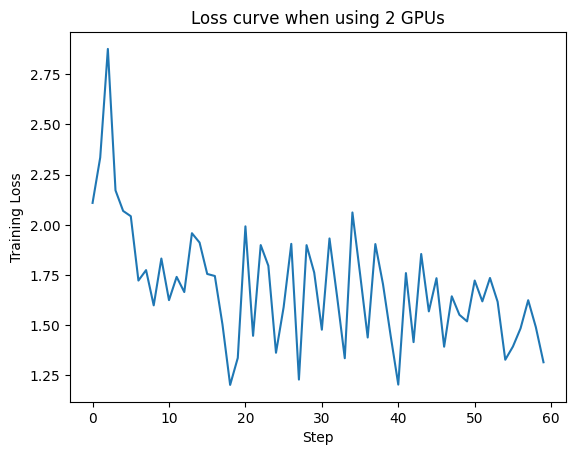

In [8]:
#@title Show and export loss curve for 2x GPU
import matplotlib.pyplot as plt
import json
train_loss = []
with open("/kaggle/working/outputs-2xGPU/checkpoint-60/trainer_state.json", "r") as f:
    trainer_state = json.load(f)
for elem in trainer_state["log_history"]:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])
plt.plot(train_loss)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title(f"Loss curve when using 2 GPUs")
plt.savefig(f"llama_8b_2x_GPU_loss_curve.png")

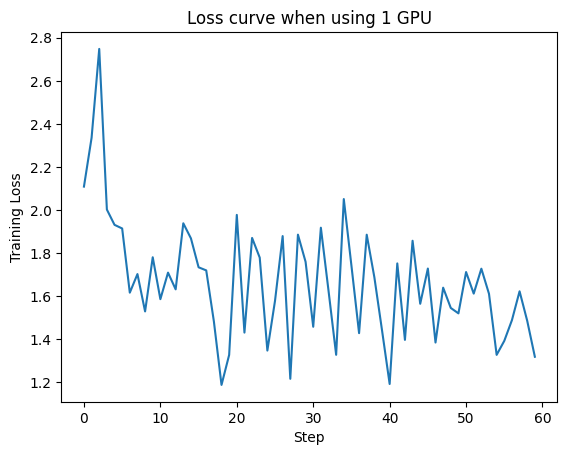

In [9]:
#@title Show and export loss curve for 1x GPU
import matplotlib.pyplot as plt
import json
train_loss = []
with open("/kaggle/working/outputs-1xGPU/checkpoint-60/trainer_state.json", "r") as f:
    trainer_state = json.load(f)
for elem in trainer_state["log_history"]:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])
plt.plot(train_loss)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title(f"Loss curve when using 1 GPU")
plt.savefig(f"llama_8b_1x_GPU_loss_curve.png")

In [10]:
# Because colab, kaggle, and github notebook implementations are not uniform...
from ipywidgets import Widget
Widget.close_all()